In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import scipy
import csv

from poisson_process import NHPoissonProcess
from mcmc import PoissonMCMC
from visualisation import plot_trace, plot_densities, plot_autocorr, plot_ess
from parameters.params import Params
from densities import gpd_quantile
from rhat_infinity import *


In [2]:
from IPython.display import display


# Parameters loading


In [3]:
poisson_params_directory = "parameters/poisson_simu/"

poisson_config = "sharkey_poisson_config"
# poisson_config = "tony_poisson_config"
# poisson_config = "negative_xi_config"

poisson_params = Params(poisson_params_directory + poisson_config + ".json")

mcmc_params_directory = "parameters/mcmc/"
mcmc_configs = ["Config5.json"]

# mcmc_configs = []
# for filename in os.listdir(mcmc_params_directory):
#     if "json" in filename:
#         mcmc_configs.append(filename)

estimator = "mean"


# Data simulation

Poisson process parameter: (mu = 80, sigma = 15, xi = 0.05)
Orthogonal version: (r = 38.34, nu = 13.12, xi = 0.05)
Expected number of points: 38.34
Number of generated points: 34
Min: 30.336
Max: 66.535

Estimation of quantiles 1/38, 1/76 and 1/115 
Theoretical values of quantiles: 80.000, 90.579, 96.940


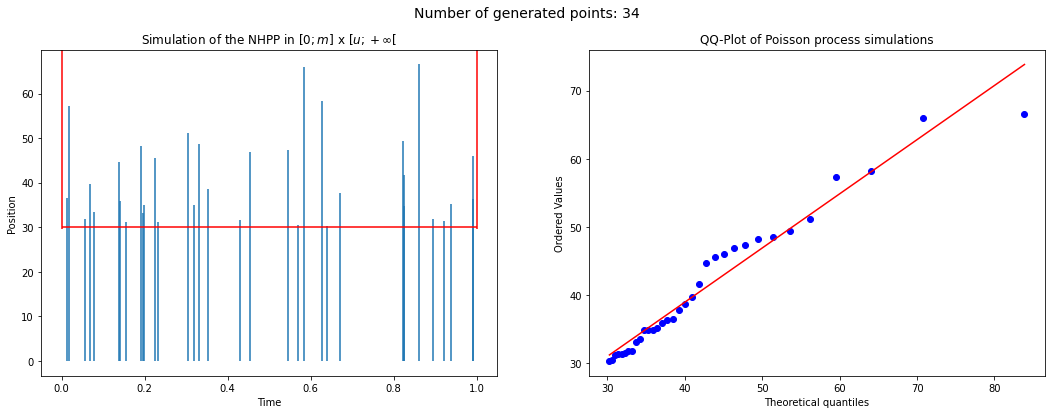

In [4]:
PP = NHPoissonProcess(mu=poisson_params.mu, sig=poisson_params.sigma, xi=poisson_params.xi,
                      u=poisson_params.u, m=poisson_params.m)

lam_obs = PP.get_measure()
n_obs = PP.gen_number_points()[0]

obs = PP.gen_positions(n_obs=n_obs)
times = PP.gen_time_events(n_obs=n_obs)

pp_params = PP.get_parameters()
print("Poisson process parameter: (mu = {}, sigma = {}, xi = {})".format(pp_params[2],
                                                                         pp_params[3],
                                                                         pp_params[4]))
ortho_params = PP.get_orthogonal_reparam()
print("Orthogonal version: (r = {:.2f}, nu = {:.2f}, xi = {})".format(ortho_params[0],
                                                                      ortho_params[1],
                                                                      ortho_params[2]))
print("Expected number of points: {:.2f}".format(lam_obs))
print("Number of generated points:", n_obs)
print("Min: {:.3f}".format(np.min(obs)))
print("Max: {:.3f}".format(np.max(obs)))

quantiles = (1/lam_obs, 1/(2*lam_obs), 1/(3*lam_obs))
print("\nEstimation of quantiles 1/{}, 1/{} and 1/{} ".format(int(lam_obs), int(2*lam_obs), int(3*lam_obs)))
sig_tilde = pp_params[3]+pp_params[4]*(pp_params[0]-pp_params[2])
real_q1 = gpd_quantile(prob=quantiles[0], mu=pp_params[0], sig=sig_tilde, xi=pp_params[4])
real_q2 = gpd_quantile(prob=quantiles[1], mu=pp_params[0], sig=sig_tilde, xi=pp_params[4])
real_q3 = gpd_quantile(prob=quantiles[2], mu=pp_params[0], sig=sig_tilde, xi=pp_params[4])
print("Theoretical values of quantiles: {:.3f}, {:.3f}, {:.3f}".format(real_q1, real_q2, real_q3))

PP.plot_simulation(times=times, positions=obs)


# MCMC


Config file:  Config5.json
Jeffreys prior on orthogonal parameters

Choice of m = 1 for MCMC

 Summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,mode
mu_m,68.408,12.314,55.742,84.564,0.322,0.227,1466.0,1466.0,1081.0,1657.0,1.0,74.306
sig_m,8.906,10.938,2.726,19.546,0.267,0.189,1680.0,1680.0,651.0,1119.0,1.0,13.176
xi,-0.194,0.219,-0.500,0.180,0.008,0.006,767.0,727.0,625.0,720.0,1.0,-0.089


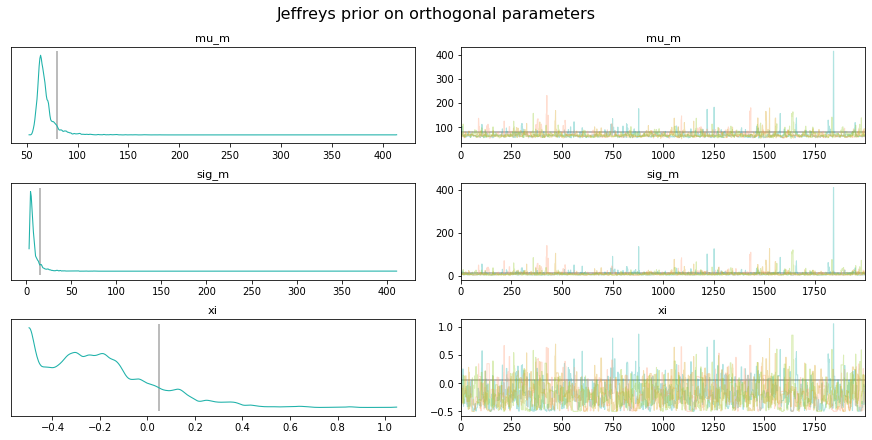


 Quantiles Summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,mode
q1r,69.217,12.616,56.268,86.044,0.332,0.235,1445.0,1445.0,1041.0,1614.0,1.0,60.328
q2r,75.420,22.093,59.123,100.070,0.548,0.388,1626.0,1626.0,978.0,1876.0,1.0,72.163
q3r,79.181,30.713,60.408,109.767,0.726,0.514,1788.0,1788.0,947.0,1891.0,1.0,66.262


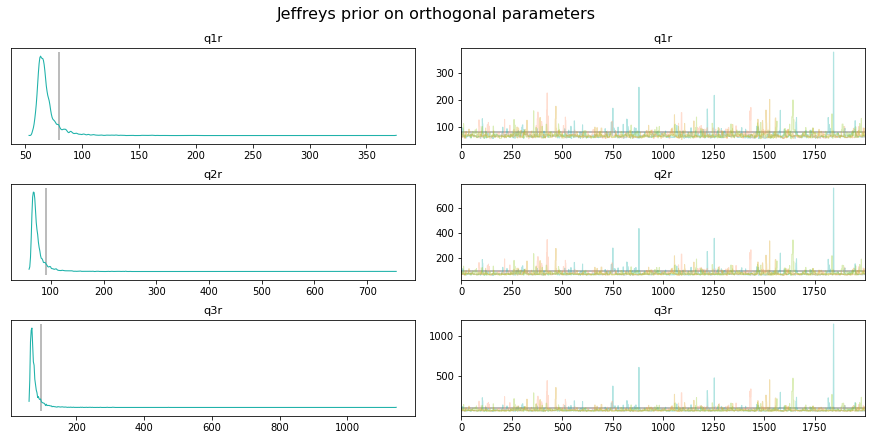

In [5]:
traces = []
traces_orthogonal = []
names = []
names_orthogonal = []

func_dict = {"mode": lambda x: scipy.stats.mode(x, axis=None).mode[0]}


for filename in mcmc_configs:
    print("\nConfig file: ", filename)
    mcmc_params = Params(mcmc_params_directory + filename)
    print(mcmc_params.name)
    print("")
    
    priors = [mcmc_params.priors["p1"],
              mcmc_params.priors["p2"],
              mcmc_params.priors["p3"]]

    if mcmc_params.init_p1_by_u:
        init_val = n_obs if mcmc_params.orthogonal_param else poisson_params.u
        priors[0] = priors[0].replace("u", str(init_val))

    MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter,
                       obs=obs, u=poisson_params.u, m=poisson_params.m, quantiles=quantiles,
                       orthogonal_param=mcmc_params.orthogonal_param)
    if mcmc_params.update_m != "":
        MCMC.update_m(update_arg=mcmc_params.update_m, xi=poisson_params.xi)
    print("Choice of m = {} for MCMC".format(MCMC.m))

    trace = MCMC.run(verbose=False)

    names.append(mcmc_params.name)
    traces.append(trace)
    
    print("\n Summary:")
    display(az.summary(data=trace, stat_funcs=func_dict, var_names=["mu_m", "sig_m", "xi"]))
    plot_trace(trace, var_names=["mu_m", "sig_m", "xi"], title=mcmc_params.name, real_value=pp_params[2:5])
    plt.show()

    
    print("\n Quantiles Summary:")
    display(az.summary(data=trace, stat_funcs=func_dict, var_names=["q1r", "q2r", "q3r"]))
    plot_trace(trace, var_names=["q1r", "q2r", "q3r"], title=mcmc_params.name, real_value=[real_q1, real_q2, real_q3])
    plt.show()


    # if MCMC.orthogonal_param:
    #     plot_trace(trace, var_names=["r", "nu", "xi"], title=mcmc_params.name)
    #     names_orthogonal.append(mcmc_params.name)
    #     traces_orthogonal.append(trace)
    

In [6]:
if mcmc_configs == ["Config6.json"]:
    prior_pc = MCMC.prior_predictive_check(nsamples=1000)
    plt.figure(figsize=(18, 12))
    plt.hist(np.log([max(dataset) for dataset in prior_pc["gpd"]]), bins = 20, edgecolor='black', color = "lightblue")
    plt.axvline(np.log(max(obs)), linestyle='dashed', linewidth=1)
    plt.show()

In [7]:
ppc = MCMC.posterior_predictive_check(trace)

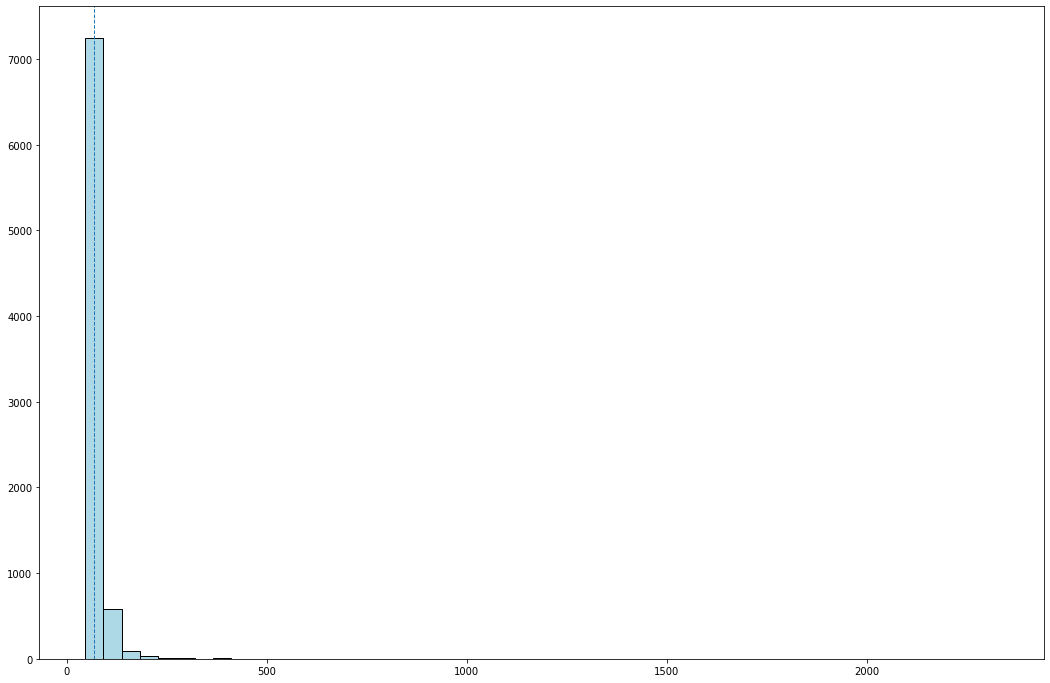

In [8]:
plt.figure(figsize=(18, 12))
plt.hist([max(dataset) for dataset in ppc["gpd"]], bins = 50, edgecolor='black', color = "lightblue")
plt.axvline(max(obs), linestyle='dashed', linewidth=1)
plt.show()

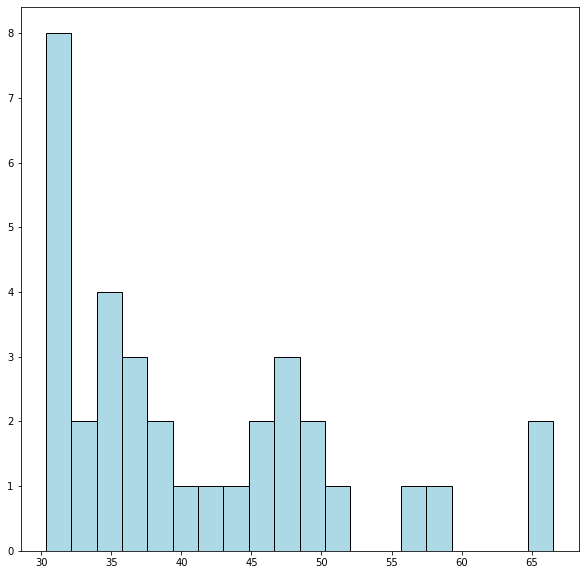

In [9]:
plt.figure(figsize=(10, 10))
plt.hist(obs, bins = 20, edgecolor='black', color = "lightblue")
plt.show()

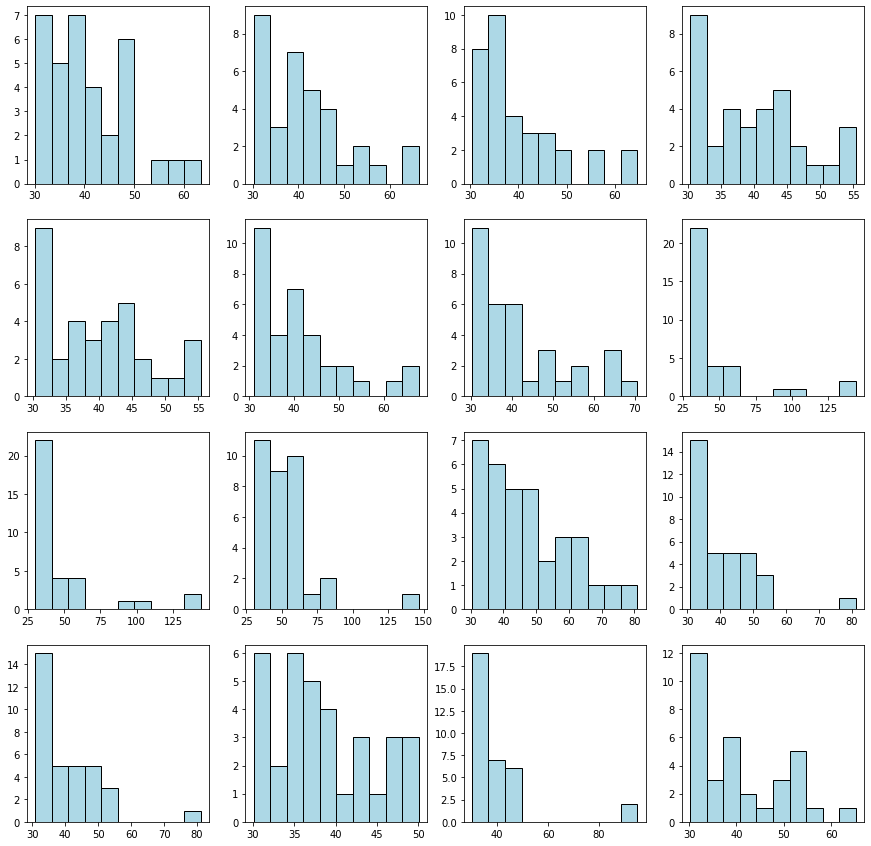

In [10]:
dim = 4
fig, ax = plt.subplots(dim, dim, figsize=(15,15))
for i in range(dim):
    for j in range(dim):
        ax[i,j].hist(ppc["gpd"][3*i+j], bins = 10, edgecolor='black', color = "lightblue")
plt.show()

## Autocorrelations and ESS on parameters

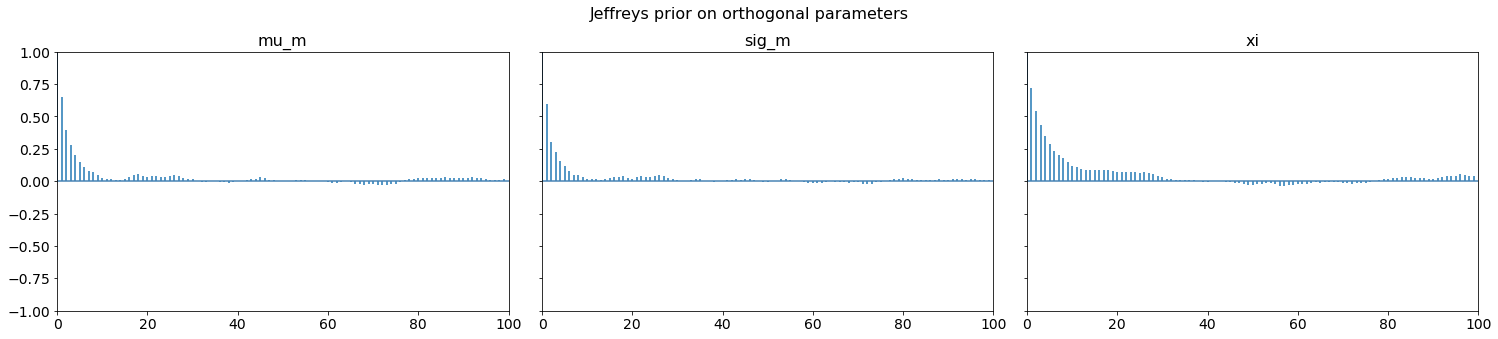

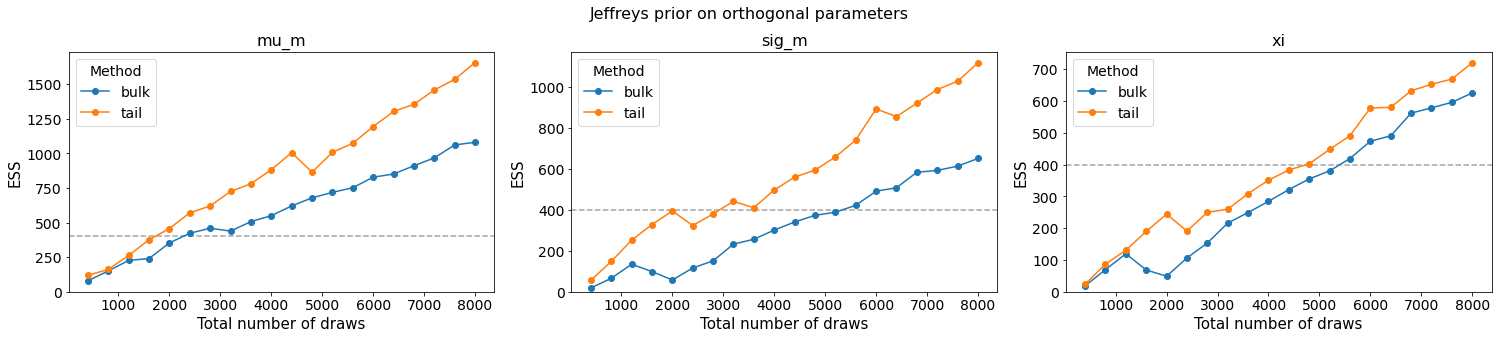

In [11]:
plot_autocorr(traces=traces, labels=names, var_names=["mu_m", "sig_m", "xi"])
plot_ess(traces=traces, labels=names, var_names=["mu_m", "sig_m", "xi"])
plt.show()

## Autocorrelations and ESS on quantile estimation

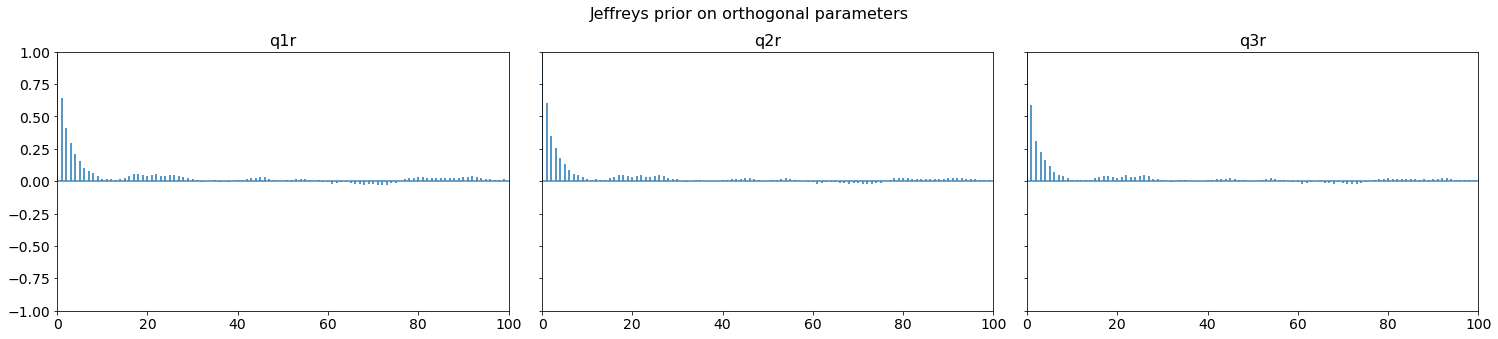

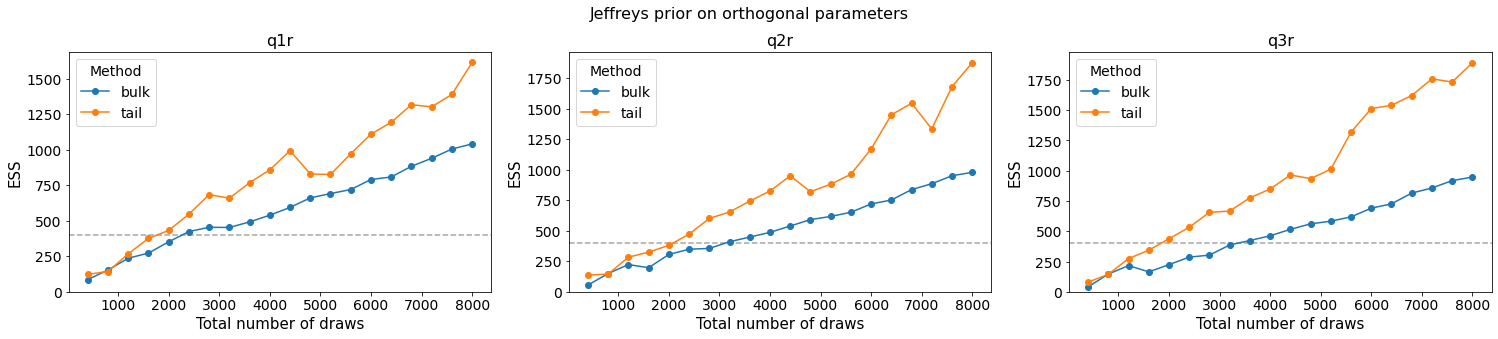

In [12]:
plot_autocorr(traces=traces, labels=names, var_names=["q1r", "q2r", "q3r"])
plot_ess(traces=traces, labels=names, var_names=["q1r", "q2r", "q3r"])
plt.show()

In [13]:
localrhat_summary(data=trace, var_names=["r", "nu", "xi"])


Multivariate R-hat-infinity on all dependence directions: 1.009 (threshold: 1.043)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,r_threshold,r_hat_inf
r,35.443,5.917,24.640,46.488,0.180,0.127,1078.0,1078.0,1056.0,1434.0,1.01,1.031,1.010
nu,11.163,1.682,8.363,14.446,0.051,0.036,1099.0,1085.0,1192.0,1140.0,1.00,1.031,1.005
xi,-0.194,0.219,-0.500,0.180,0.008,0.006,767.0,727.0,625.0,720.0,1.00,1.031,1.007


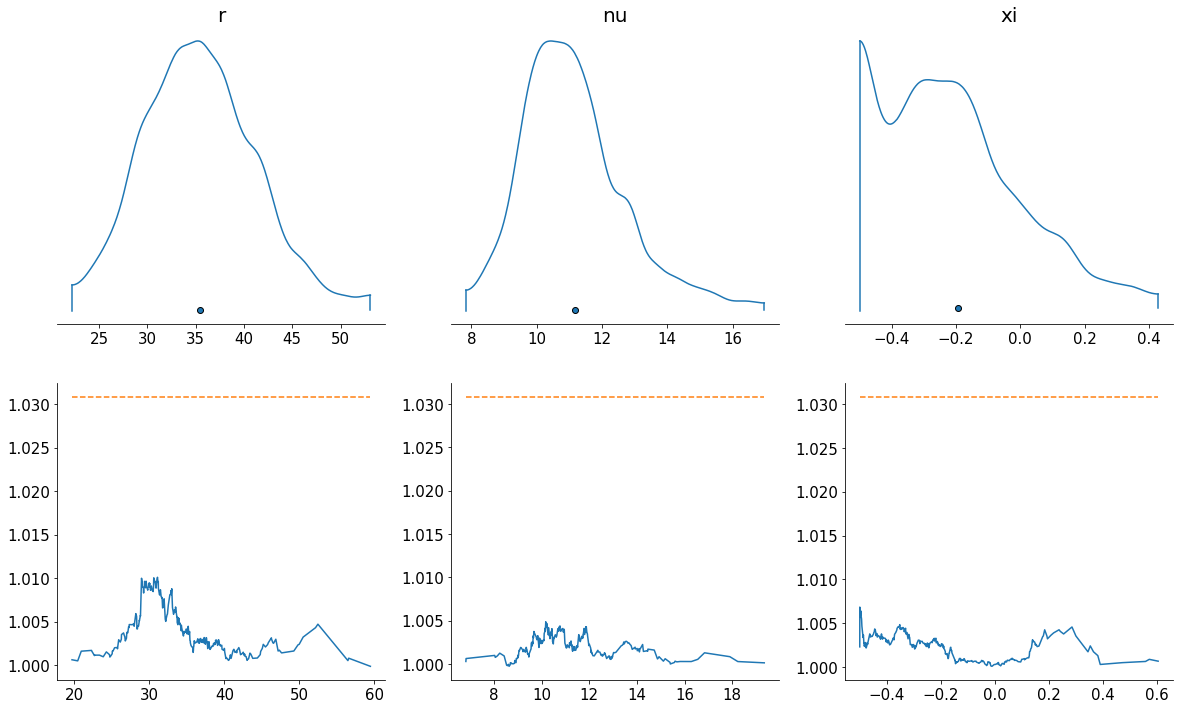

In [14]:
var_names = ["r", "nu", "xi"]
nb_var = len(var_names)

m = len(trace.posterior.chain)

_, ax = plt.subplots(2, nb_var, figsize=(20, 12))

az.plot_density(data=trace,
                var_names=var_names,
                ax=ax, bw="scott",
                hdi_prob = 0.99)


[ax[0,i].spines["left"].set_visible(False) for i in range(nb_var)]
[a.spines["right"].set_visible(False) for line in ax for a in line]
[a.spines["top"].set_visible(False) for line in ax for a in line]

for i in range(nb_var):
    
#     ax[1,i].cla()
    chains = np.asarray(traces[0].posterior[var_names[i]]).transpose(1,0)
    grid, r_val = r_x_values(chains)
    ax[1,i].plot(grid, r_val)
    ax[1,i].plot(grid, [get_threshold(2*m)]*len(grid), linestyle="--")

    
    ax[0,i].xaxis.set_tick_params(labelsize = 15)
    ax[0,i].yaxis.set_tick_params(labelsize = 15)
    ax[1,i].xaxis.set_tick_params(labelsize = 15)
    ax[1,i].yaxis.set_tick_params(labelsize = 15)
    
    ax[0,i].set_title(var_names[i], fontsize = 20)


plt.show()

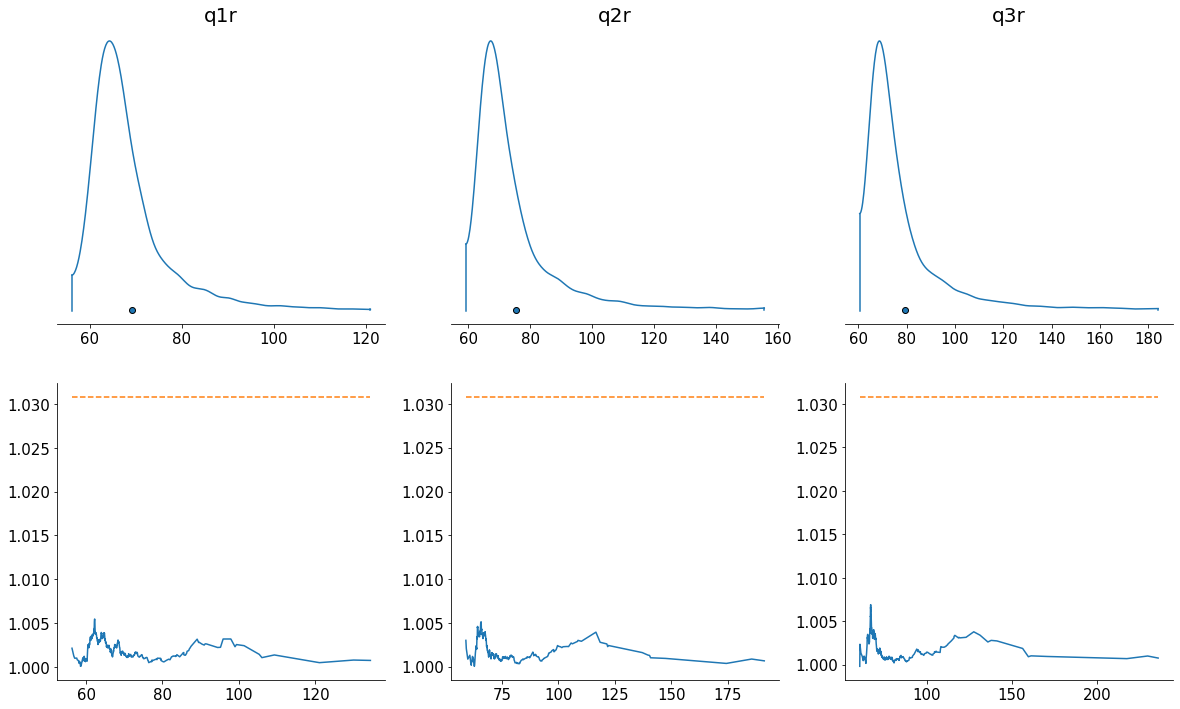

In [15]:
var_names = ["q1r", "q2r", "q3r"]
nb_var = len(var_names)

m = len(trace.posterior.chain)

_, ax = plt.subplots(2, nb_var, figsize=(20, 12))

az.plot_density(data=trace,
                var_names=var_names,
                ax=ax, bw="scott",
                hdi_prob = 0.99)


[ax[0,i].spines["left"].set_visible(False) for i in range(nb_var)]
[a.spines["right"].set_visible(False) for line in ax for a in line]
[a.spines["top"].set_visible(False) for line in ax for a in line]

for i in range(nb_var):
    
#     ax[1,i].cla()
    chains = np.asarray(traces[0].posterior[var_names[i]]).transpose(1,0)
    grid, r_val = r_x_values(chains)
    ax[1,i].plot(grid, r_val)
    ax[1,i].plot(grid, [get_threshold(2*m)]*len(grid), linestyle="--")

    
    ax[0,i].xaxis.set_tick_params(labelsize = 15)
    ax[0,i].yaxis.set_tick_params(labelsize = 15)
    ax[1,i].xaxis.set_tick_params(labelsize = 15)
    ax[1,i].yaxis.set_tick_params(labelsize = 15)
    
    ax[0,i].set_title(var_names[i], fontsize = 20)


plt.show()

In [16]:
# with 
#     pm.sample_posterior_predictive(trace)

In [17]:
break

SyntaxError: 'break' outside loop (<ipython-input-17-6aaf1f276005>, line 4)

# Repeated simulations

In [ ]:
print("Poisson process parameter: (mu = {}, sigma = {}, xi = {})".format(pp_params[2],
                                                                         pp_params[3],
                                                                         pp_params[4]))

print("Real values of quantiles: {:.3f}, {:.3f}, {:.3f}".format(real_q1, real_q2, real_q3))


verbose = False

nb_repetitions = 100

all_summaries = []
all_summaries_quantile = []

for idx_config, filename in enumerate(mcmc_configs):
    print("\n##### Config file: {} #####".format(filename))
    mcmc_params = Params(mcmc_params_directory + filename)
    print(mcmc_params.name)

    priors = [mcmc_params.priors["p1"],
              mcmc_params.priors["p2"],
              mcmc_params.priors["p3"]]

    if mcmc_params.init_p1_by_u:
        init_val = n_obs if mcmc_params.orthogonal_param else poisson_params.u
        priors[0] = priors[0].replace("u", str(init_val))

    summaries = []
    summaries_quantile = []
    for i in range(nb_repetitions):
        
        PP = NHPoissonProcess(mu=poisson_params.mu, sig=poisson_params.sigma, xi=poisson_params.xi,
                      u=poisson_params.u, m=poisson_params.m)

        n_obs = PP.gen_number_points()[0]
        obs = PP.gen_positions(n_obs=n_obs)
        
        if verbose:
            print("\nSimulation {}:".format(i+1))
            print("    Number of generated points:", n_obs)
        else:
            print("\r     Simulation {}/{}".format(i+1,nb_repetitions), end="")

        pp_params = PP.get_parameters()
        
        MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter, quantiles=quantiles,
                           obs=obs, u=poisson_params.u, m=poisson_params.m, orthogonal_param=mcmc_params.orthogonal_param)
        
        if mcmc_params.update_m != "":
            MCMC.update_m(update_arg=mcmc_params.update_m, xi=poisson_params.xi)
        
        trace = MCMC.run(verbose=False)

        df = az.summary(data=trace, stat_funcs=func_dict, var_names=["mu_m", "sig_m", "xi"])
        df["group"] = ["mu","sig","xi"]
        summaries.append(df)
        
        if verbose:
            print("    Choice of m = {} for MCMC".format(MCMC.m))
            print("\n Summary:")

            display(summaries[i])
            plot_trace(trace, var_names=["mu_m", "sig_m", "xi"], title=mcmc_params.name, real_value=pp_params[2:5])
            plt.show()
        
        
        df_q = az.summary(data=trace, stat_funcs=func_dict, var_names=["q1r", "q2r", "q3r"])
        df_q["group"] = ["q1","q2","q3"]
        summaries_quantile.append(df_q)
    
    summaries_df = pd.concat(summaries, ignore_index=True)
    summaries_df["config"] = "Config. "+str(idx_config+1)
    all_summaries.append(summaries_df)
    
    summaries_quantile_df = pd.concat(summaries_quantile, ignore_index=True)
    summaries_quantile_df["config"] = "Config. "+str(idx_config+1)
    all_summaries_quantile.append(summaries_quantile_df)
    
    print("\n\n")
    print('Mean of summaries:')
    display(summaries_df.groupby('group').mean())
    var = list(summaries_df.groupby('group').var()[estimator])
    print('Variance of posterior means: {:.3f}, {:.3f}, {:.3f}'.format(var[0], var[1], var[2]))

    print('\nMean of summaries for quantiles:')
    display(summaries_quantile_df.groupby('group').mean())
    var_q = list(summaries_quantile_df.groupby('group').var()[estimator])
    print('Variance of posterior means for quantiles: {:.3f}, {:.3f}, {:.3f}'.format(var_q[0], var_q[1], var_q[2]))

all_summaries_df = pd.concat(all_summaries, ignore_index=True)
all_summaries_quantile_df = pd.concat(all_summaries_quantile, ignore_index=True)

In [ ]:
all_summaries_df[all_summaries_df["group"] == "mu"]

In [ ]:


fig, axes = plt.subplots(1, 3, figsize=(20,10))

ax = sns.boxplot(y=estimator, x="config", data = all_summaries_df[all_summaries_df["group"] == "mu"], width=0.5, ax=axes.flatten()[0])
# ax.set_ylim(mu_means.min()*0.99, mu_means.max()*1.01)
ax.tick_params(labelsize=13)
ax.axhline(pp_params[2], ls='--', c='grey')
ax = sns.swarmplot(y=estimator, x="config", data = all_summaries_df[all_summaries_df["group"] == "mu"], color="black", alpha=0.7, size=6-nb_repetitions/100, ax=axes.flatten()[0])
ax.set_ylabel("Posterior Means", fontsize=18)
ax.set_xlabel("$\mu$", fontsize=20)



ax = sns.boxplot(y=estimator, x="config", data = all_summaries_df[all_summaries_df["group"] == "sig"], width=0.5, ax=axes.flatten()[1])
# ax.set_ylim(sig_means.min()*0.99, sig_means.max()*1.01)
ax.tick_params(labelsize=13)
ax.axhline(pp_params[3], ls='--', c='grey')
ax = sns.swarmplot(y=estimator, x="config", data = all_summaries_df[all_summaries_df["group"] == "sig"], color="black", alpha=0.7, size=6-nb_repetitions/100, ax=axes.flatten()[1])
ax.set_ylabel("", fontsize=15)
ax.set_xlabel("$\sigma$", fontsize=20)



ax = sns.boxplot(y=estimator, x="config", data = all_summaries_df[all_summaries_df["group"] == "xi"], width=0.5, ax=axes.flatten()[2])
# ax.set_ylim(xi_means.min()*1.01, xi_means.max()*1.01)
ax.tick_params(labelsize=13)
ax.axhline(pp_params[4], ls='--', c='grey')
ax = sns.swarmplot(y=estimator, x="config", data = all_summaries_df[all_summaries_df["group"] == "xi"], color="black", alpha=0.7, size=6-nb_repetitions/100, ax=axes.flatten()[2])
ax.set_ylabel("", fontsize=15)
ax.set_xlabel("$\\xi$", fontsize=20)




plt.show()


In [ ]:


fig, axes = plt.subplots(1, 3, figsize=(20,10))

ax = sns.boxplot(y=estimator, x="config", data = all_summaries_quantile_df[all_summaries_quantile_df["group"] == "q1"], width=0.5, ax=axes.flatten()[0])
# ax.set_ylim(mu_means.min()*0.99, mu_means.max()*1.01)
ax.tick_params(labelsize=13)
ax.axhline(real_q1, ls='--', c='grey')
ax = sns.swarmplot(y=estimator, x="config", data = all_summaries_quantile_df[all_summaries_quantile_df["group"] == "q1"], color="black", alpha=0.7, size=6-nb_repetitions/100, ax=axes.flatten()[0])
ax.set_ylabel("Posterior Means", fontsize=18)
ax.set_xlabel("$q(1/r)$", fontsize=20)



ax = sns.boxplot(y=estimator, x="config", data = all_summaries_quantile_df[all_summaries_quantile_df["group"] == "q2"], width=0.5, ax=axes.flatten()[1])
# ax.set_ylim(sig_means.min()*0.99, sig_means.max()*1.01)
ax.tick_params(labelsize=13)
ax.axhline(real_q2, ls='--', c='grey')
ax = sns.swarmplot(y=estimator, x="config", data = all_summaries_quantile_df[all_summaries_quantile_df["group"] == "q2"], color="black", alpha=0.7, size=6-nb_repetitions/100, ax=axes.flatten()[1])
ax.set_ylabel("", fontsize=15)
ax.set_xlabel("$q(1/2r)$", fontsize=20)



ax = sns.boxplot(y=estimator, x="config", data = all_summaries_quantile_df[all_summaries_quantile_df["group"] == "q3"], width=0.5, ax=axes.flatten()[2])
# ax.set_ylim(xi_means.min()*1.01, xi_means.max()*1.01)
ax.tick_params(labelsize=13)
ax.axhline(real_q3, ls='--', c='grey')
ax = sns.swarmplot(y=estimator, x="config", data = all_summaries_quantile_df[all_summaries_quantile_df["group"] == "q3"], color="black", alpha=0.7, size=6-nb_repetitions/100, ax=axes.flatten()[2])
ax.set_ylabel("", fontsize=15)
ax.set_xlabel("$q(1/3r)$", fontsize=20)




plt.show()
